In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
%matplotlib inline

import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

In [35]:
def aligment_rotation(reference, not_reference):
    
    ref = mda.Universe(reference)
    mobile = mda.Universe(not_reference)
    
    ref0 = ref.select_atoms('name CA').positions - ref.atoms.center_of_mass()
    mobile0 = mobile.select_atoms('name CA').positions - mobile.atoms.center_of_mass()
    mobile_all = mobile.select_atoms('all').positions - mobile.atoms.center_of_mass()
    
    Ra, rmsd = align.rotation_matrix(mobile0, ref0)
    mobile_rotated=np.dot(Ra, mobile_all.T)
    
    return (Ra, mobile_rotated)

def aligment_rotation_coord(reference, not_reference):
    
    Ra, mobile_rotated = aligment_rotation(reference, not_reference)
    
    mobile_rot_x=mobile_rotated[0]
    mobile_rot_y=mobile_rotated[1]
    mobile_rot_z=mobile_rotated[2]
    
    return (mobile_rot_x, mobile_rot_y, mobile_rot_z)

def quaternion_rotation(q, x, y, z):
    
    Q = R.from_quat(q).as_matrix()
    
    coord = np.array([x,y,z])
    rot_coord = np.dot(Q, coord)
    
    x_rot = rot_coord[0]
    y_rot = rot_coord[1]
    z_rot = rot_coord[2]
    
    return(x_rot, y_rot, z_rot)

def i_sel (x,xi,sigma,n):
    
    return (i for i in range(len(x)) if abs(x[i]-xi)<=n*sigma)

def I_calculated (x_atom, y_atom, sigma, n, res):
    
    x = np.linspace(min(x_atom)-1,max(x_atom)+1, res)
    y = np.linspace(min(y_atom)-1,max(y_atom)+1, res)
    
    Ixy = 0    
    for atom in range(len(x_atom)):
        
        X = np.zeros(len(x))
        Y = np.zeros(len(x))
        
        i_x_selected=list(i_sel (x,x_atom[atom],sigma,n))
        i_y_selected=list(i_sel (y,y_atom[atom],sigma,n))
        
        X[i_x_selected]=np.exp(-0.5*(((x[i_x_selected]-x_atom[atom])/sigma)**2))
        Y[i_y_selected]=np.exp(-0.5*(((y[i_y_selected]-y_atom[atom])/sigma)**2))
        
        Ixy += np.array([X[i]*Y for i in range(len(x))])
        
    return(np.sqrt(2*np.pi)*sigma*Ixy)

def collective_variable(Ical, I):
    
    s=0
    for x in range(len(Ical)):
        for y in range(len(Ical)):
            s+=Ical[x,y]*I[x,y]
            
    return(-s) 

def gradient_s_xy(Ical, I, sigma, x_grid, y_grid, x_atom, y_atom):
    
    Sxy=np.diagonal(np.dot(Ical, I.T))
    Syx=np.diagonal(np.dot(Ical.T, I))
    
    gradx=[]
    grady=[]
    
    for atom in range(len(x_atom)):
        gradx.append(np.dot(x_grid-x_atom[atom],Sxy))
        grady.append(np.dot(y_grid-y_atom[atom],Syx))
        
    gradx=np.array(gradx)
    grady=np.array(grady)
    
    return(-gradx/(sigma**2), -grady/(sigma**2))

def gradient_s_xy_test(Ical, I, sigma, x_grid, y_grid, x_atom, y_atom):
    
    gradx=np.zeros(len(x_atom))
    grady=np.zeros(len(y_atom))
    
    for atom in range(len(x_atom)):
        gradx_cont=0
        grady_cont=0
        for i in range(len(Ical)):
            for j in range(len(Ical)):
                gradx_cont+=(x_grid[i]-x_atom[atom])*Ical[i,j]*I[i,j]
                grady_cont+=(y_grid[j]-y_atom[atom])*Ical[i,j]*I[i,j]
                
        gradx[atom]=gradx_cont
        grady[atom]=grady_cont

    return(-gradx/(sigma**2), -grady/(sigma**2))

def gradient_descent(Ixy, x_grid, y_grid, x_atom, y_atom, grad_x, grad_y, sigma, n, res, k, N):
    
    x_gd=x_atom
    y_gd=y_atom
    grad_x_gd=grad_x
    grad_y_gd=grad_y
    
    for i in tqdm(range(N)):
        x_gd = x_gd - k*grad_x_gd
        y_gd = y_gd - k*grad_y_gd
        Ixy_gd = I_calculated (x_gd, y_gd, sigma, n, res)
        grad_x_gd, grad_y_gd = gradient_s_xy(Ixy, Ixy_gd, sigma, x_grid, y_grid, mobile_x, mobile_y)
    
    s_gd=collective_variable(Ixy, Ixy_gd)
    grad_gd=grad_x_gd, grad_y_gd
    
    return (s_gd, grad_gd, Ixy_gd)

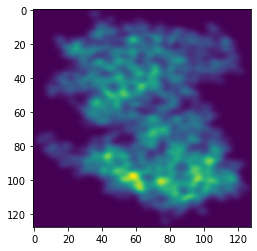

In [36]:
reference='groel_frame_13120.pdb'
not_reference='groel_apo.pdb'

q=[0,0,1/np.sqrt(2),1/np.sqrt(2)] #Quaternion parameters

n=3      #Sigma times
sigma=1  #Standar deviation of the Gaussians
res=128  #Grid's resolution

mobile_x, mobile_y, mobile_z = aligment_rotation_coord(reference, not_reference)

mobile_x, mobile_y, mobile_z = quaternion_rotation(q, mobile_x, mobile_y, mobile_z)

x_grid = np.linspace(min(mobile_x)-1,max(mobile_x)+1, res)  
y_grid = np.linspace(min(mobile_y)-1,max(mobile_y)+1, res)

Ixy=I_calculated (mobile_x, mobile_y, sigma, n, res)
plt.imshow(Ixy)
plt.show()

In [37]:
#Coordintes for random image 
mobile_x_random=np.max(mobile_x)*(2*np.random.random(len(mobile_x))-1)
mobile_y_random=np.max(mobile_y)*(2*np.random.random(len(mobile_y))-1)

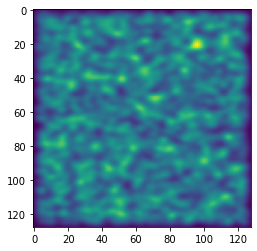

s=-4695711.8132723365 

grad_x=[34438657.32185875 30440784.04857343 34144842.90979583 ...
 75628101.11500466 79920499.50385329 76032701.3700384 ] 

grad_y=[-70120863.15054709 -72368835.51064572 -68110709.92134035 ...
 -93902792.34352478 -97892197.09289238 -98441128.10663675]


In [38]:
Ixy_random=I_calculated (mobile_x_random, mobile_y_random, sigma, n, res)
plt.imshow(Ixy_random)
plt.show()
s=collective_variable(Ixy, Ixy_random)

grad_x, grad_y=gradient_s_xy(Ixy, Ixy_random, sigma, x_grid, y_grid, mobile_x, mobile_y)
#grad_x_test, grad_y_test=gradient_s_xy_test(Ixy, Ixy_random, sigma, x_grid, y_grid, mobile_x, mobile_y)

print('s={} \n'.format(s))

print('grad_x={} \n'.format(grad_x))
#print('grad_x_test={} \n'.format(grad_x_test))

print('grad_y={}'.format(grad_y))
#print('grad_y_test={} \n'.format(grad_y_test))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.93s/it]

s_old= -4695711.8132723365
s_new= -186943.94643118218


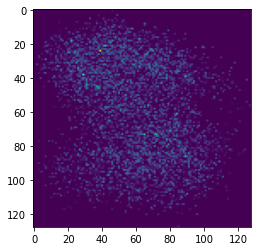

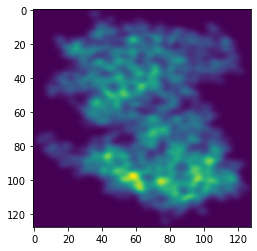

In [39]:
k=0.000001
N=5
s_gd, grad_gd, Ixy_gd = gradient_descent(Ixy, x_grid, y_grid, mobile_x_random, mobile_y_random, grad_x, grad_y, sigma, n, res, k, N)

print('s_old=',s)
print('s_new=',s_gd)
plt.imshow(Ixy_gd)
plt.show()

plt.imshow(Ixy)
plt.show()